In [1]:
import timeflow as tflow
import timesynth as ts
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Dataset generation using TimeSynth

In [2]:
#Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=20)
#Sampling regular time samples
regular_time_samples = time_sampler.sample_regular_time(num_points=200)

In [3]:
#Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.25)

In [4]:
#Initializing Gaussian noise
#white_noise = ts.noise.GaussianNoise(std=0.3)

In [5]:
#Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=None)
#Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(regular_time_samples)

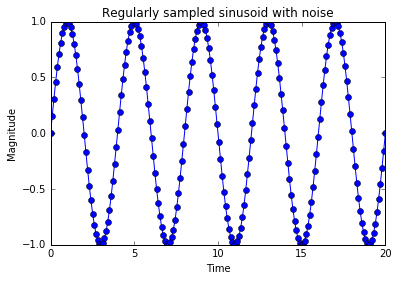

In [6]:
#Plotting the series
plt.plot(regular_time_samples, samples, marker='o')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Regularly sampled sinusoid with noise')

#### Building training and testing set

In [7]:
num_training_points = 100
X = samples[:-1]
Y = samples[1:]
X_train = X[:num_training_points]
Y_train = Y[:num_training_points]
X_test = X[num_training_points:]
Y_test = Y[num_training_points:]
X_train = np.reshape(X_train,(len(X_train), 1))
Y_train = np.reshape(Y_train,(len(Y_train), 1))
X_test = np.reshape(X_test,(len(X_test), 1))
Y_test = np.reshape(Y_test,(len(Y_test), 1))

#### Building the network

In [8]:
input_size = 1
hidden_size = 10
output_size = 1

In [9]:
inputs = tflow.placeholders.prediction.input_placeholder(input_size)
input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size)
lstm_layer = tflow.layers.LSTMLayer(input_size, hidden_size, input_lstm_layer)
reg_layer = tflow.layers.RegressionLayer(hidden_size, output_size, lstm_layer)
output_layer = tflow.layers.OutputLSTMLayer(output_size, reg_layer)

In [10]:
y = tflow.placeholders.prediction.output_placeholder(output_size)

In [11]:
outputs = output_layer.get_outputs()
# Defining MSE as the loss function
loss_func = tf.reduce_mean(tf.pow(tf.sub(outputs, y),2))

In [12]:
# Training with Adadelta Optimizer
train_step = tf.train.RMSPropOptimizer(learning_rate=0.05).minimize(loss_func)

In [13]:
# Starting tensorflow session
sess=tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [15]:
for i in range(100):
    sess.run(train_step,feed_dict={inputs:X_train, y:Y_train})
    if (i+1)%10 == 0:
        print i+1, str(sess.run(loss_func,feed_dict={inputs:X_train, y:Y_train}))

10 0.482499
20 0.481656
30 0.481506
40 0.480704
50 0.469875
60 0.234282
70 0.0135658
80 0.0144253
90 0.0240101
100 0.0191846


#### Test output

#### Automated Training

In [14]:
class AutomatedTrainingMonitor:
    
    def __init__(self, input_var, output_var, training_input, training_output, 
                 train, cost, sess, training_steps=100,
                 validation_input=None, validation_output=None,
                 early_stopping_rounds=None):
        self.input_var = input_var
        self.output_var = output_var
        self.sess = sess
        self.cost = cost
        self.train_step = train
        self.training_input = training_input
        self.training_output = training_output
        self.training_steps = training_steps
        self.validation_input = validation_input
        self.validation_output = validation_output
        self.early_stopping_rounds = early_stopping_rounds
        self._best_value_step = None
        self._best_value = None
        self._early_stopped = False
        self._latest_path = None
        self._latest_path_step = None
    
    @property
    def early_stopped(self):
        """Returns True if this monitor caused an early stop."""
        return self._early_stopped

    @property
    def best_step(self):
        """Returns the step at which the best early stopping metric was found."""
        return self._best_value_step

    @property
    def best_value(self):
        """Returns the best early stopping metric value found so far."""
        return self._best_value
    
    def validate_every_step(self, step):
        if self.early_stopping_rounds is not None:
            current_value = float(self.sess.run(self.cost,feed_dict={self.input_var:self.validation_input, 
                                                                     self.output_var:self.validation_output}))
            if (self._best_value is None or current_value < self._best_value):
                self._best_value = current_value
                self._best_value_step = step
            stop_now = (step - self._best_value_step >= self.early_stopping_rounds)
            if stop_now:
                self._early_stopped = True
        return
                
    def train(self):
        for iter_num in range(self.training_steps):
            self.sess.run(self.train_step,feed_dict={self.input_var:self.training_input,
                                                     self.output_var:self.training_input})
            self.validate_every_step(iter_num)
            if self._early_stopped is True:
                break
        print "Final Validation loss: ",\
              float(self.sess.run(self.cost,feed_dict={self.input_var:self.validation_input, 
                                                       self.output_var:self.validation_output}))
        print "Number of Iterations: ",\
              iter_num

In [18]:
monitor = AutomatedTrainingMonitor(inputs, y, X_train, Y_train,
                                   train_step, loss_func, sess, training_steps=500,
                                   validation_input=X_test, validation_output=Y_test,
                                   early_stopping_rounds=60)

In [19]:
monitor.train()

Final Validation loss:  0.0189358014613
Number of Iterations:  119


In [20]:
output = sess.run(outputs,feed_dict={inputs:X_test})

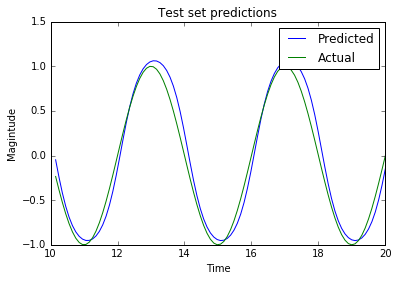

In [21]:
plt.plot(regular_time_samples[num_training_points+1:], output, label = 'Predicted')
plt.plot(regular_time_samples[num_training_points+1:], Y_test, label = 'Actual')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magintude')
plt.title('Test set predictions');